In [1]:
!pip install --user face-recognition

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import sampler
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm, trange
import xml.etree.ElementTree as ET
import copy
import face_recognition

In [3]:
dtype = torch.float32 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [4]:
widths = []
heights = []
for annotation_file in sorted(os.listdir('./annotations')):
    annotation_path = os.path.join('./annotations', annotation_file)

    # https://www.kaggle.com/bitthal/understanding-input-data-and-loading-with-pytorch
    tree = tree = ET.parse(annotation_path)
    root = tree.getroot()
    objects = root.findall('object')
    for obj in objects:
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        widths.append(xmax - xmin)
        heights.append(ymax - ymin)
        
np.mean(widths), np.mean(heights)

(31.149066797642437, 35.0049115913556)

In [5]:
total_num_images = 4072
train_indices = (0, int(0.80 * total_num_images))
val_indices = (int(0.80 * total_num_images), int(0.9 * total_num_images))
test_indices =  (int(0.9 * total_num_images), total_num_images)
train_indices, val_indices, test_indices

((0, 3257), (3257, 3664), (3664, 4072))

In [6]:
class FaceMaskDataset(Dataset):
    def __init__(self, img_dir, annotations_dir, indices):
        self.img_dir = img_dir
        self.label_dict = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}
        self.faces = []
        
        for annotation_file in sorted(os.listdir(annotations_dir)):
            annotation_path = os.path.join(annotations_dir, annotation_file)

            # https://www.kaggle.com/bitthal/understanding-input-data-and-loading-with-pytorch
            tree = tree = ET.parse(annotation_path)
            root = tree.getroot()
            filename = root.find('filename').text
            objects = root.findall('object')
            for obj in objects:
                label = self.label_dict[obj.find('name').text]
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                bbox = (xmin, ymin, xmax, ymax)
                self.faces.append((filename, bbox, label))
        
        self.faces = self.faces[indices[0]:indices[1]]
                        
    def __len__(self):
        return len(self.faces)

    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.faces[idx][0])
        img = Image.open(image_path).convert('RGB')
        cropped_img = img.crop(self.faces[idx][1])
        # Normalize stats from ImageNet
        compose = T.Compose([
            T.Resize((35, 35)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
        
        return compose(cropped_img), self.faces[idx][2], idx

In [7]:
train_face_mask_dataset = FaceMaskDataset(img_dir='./images', annotations_dir='./annotations', indices=train_indices)
train_face_mask_dataloader = DataLoader(train_face_mask_dataset, batch_size=128, shuffle=True)

valid_face_mask_dataset = FaceMaskDataset(img_dir='./images', annotations_dir='./annotations', indices=val_indices)
valid_face_mask_dataloader = DataLoader(valid_face_mask_dataset, batch_size=128)

test_face_mask_dataset = FaceMaskDataset(img_dir='./images', annotations_dir='./annotations', indices=test_indices)
test_face_mask_dataloader = DataLoader(test_face_mask_dataset, batch_size=128)

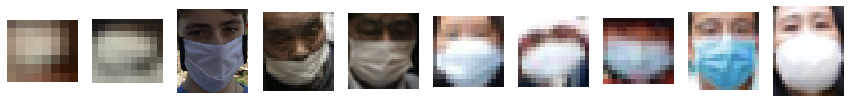

In [8]:
figs, axs = plt.subplots(1, 10, figsize=(15,15))

tmp_dataset = FaceMaskDataset(img_dir='./images', annotations_dir='./annotations', indices=test_indices)
count = 0
# Boiler plate code to display some of the images
for img, label, idx in DataLoader(tmp_dataset, batch_size=1):
    orig_image = Image.open(os.path.join(tmp_dataset.img_dir, tmp_dataset.faces[idx][0])).convert('RGB')
    cropped_img = orig_image.crop(tmp_dataset.faces[idx][1])
    axs[count].imshow(cropped_img)
    axs[count].axis('off')
    count += 1
    if count == 10:
        break

In [9]:
num_mask = 0
num_no_mask = 0
num_bad_mask = 0
for imgs, labels, _ in train_face_mask_dataloader:
    num_mask += (labels == 0).sum().item()
    num_no_mask += (labels == 1).sum().item()
    num_bad_mask += (labels == 2).sum().item()
    
num_mask, num_no_mask, num_bad_mask

(2551, 608, 98)

In [10]:
len(train_face_mask_dataloader), len(valid_face_mask_dataloader), len(test_face_mask_dataloader)

(26, 4, 4)

In [11]:
# Referenced Nikhil Pathak's ECE 176 Final Project on Image Colorization: https://github.com/nlpathak/ImageColorization
def evaluate(split, model, loss_func, current_best):
    dataloader = valid_face_mask_dataloader if split == 'val' else train_face_mask_dataloader
    losses = []
    accuracies = []
    
    model.eval() 
    with torch.no_grad():
        for imgs, labels, _ in dataloader:
            imgs = imgs.to(device=device, dtype=dtype) 
            labels = labels.to(device=device, dtype=torch.long)
            scores = model(imgs)
            
            losses.append(loss_func(scores, labels).item())
            accuracies.append(torch.sum(torch.argmax(scores, axis=1) == labels).item() / labels.shape[0])
    
    mean_loss = np.mean(losses)
    mean_acc = np.mean(accuracies)
    
    if split == 'train':
        return mean_loss, mean_acc, None
    
    if mean_loss < current_best["loss"]:
        current_best["loss"] = mean_loss
        current_best["acc"] = mean_acc
        current_best["model"] = copy.deepcopy(model)
        
    return mean_loss, mean_acc, current_best
        
def train(model, optimizer, loss_func, epochs=1):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    current_best = {
        "loss": float('inf'),
        "acc": 0, 
        "model": model
    } 
    
    model = model.to(device=device) 
    for e in trange(epochs):
        for imgs, labels, _ in train_face_mask_dataloader:
            model.train()  
            imgs = imgs.to(device=device, dtype=dtype)  
            labels = labels.to(device=device, dtype=torch.long)

            scores = model(imgs)
            loss = loss_func(scores, labels)
            
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        train_loss, train_acc, _ = evaluate('train', model, loss_func, None)    
        val_loss, val_acc, current_best = evaluate('val', model, loss_func, current_best)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch {e}, train loss = {train_losses[-1]:.6f}, train acc = {train_accs[-1]:.6f}, \
                val loss = {val_losses[-1]:.6f}, val acc = {val_accs[-1]:.6f}')
        
    return train_losses, train_accs, val_losses, val_accs, current_best

def test(model, loss_func):
    losses = []
    accuracies = []
    
    mask_total = 0
    no_mask_total = 0
    incorrect_mask_total = 0
    mask_correct = 0
    no_mask_correct = 0
    incorrect_mask_correct = 0 

    model = model.to(device=device) 

    model.eval() 
    with torch.no_grad():
        for imgs, labels, _ in test_face_mask_dataloader:
            imgs = imgs.to(device=device, dtype=dtype) 
            labels = labels.to(device=device, dtype=torch.long)
            scores = model(imgs)
            
            preds = torch.argmax(scores, axis=1)
            
            losses.append(loss_func(scores, labels).item())
            accuracies.append(torch.sum(preds == labels).item() / labels.shape[0])
            
            mask_indices = (labels == 0).nonzero()
            no_mask_indices = (labels == 1).nonzero()
            incorrect_mask_indices = (labels == 2).nonzero()
            
            mask_total += mask_indices.shape[0]
            no_mask_total += no_mask_indices.shape[0]
            incorrect_mask_total += incorrect_mask_indices.shape[0]
            
            mask_correct += torch.sum(preds[mask_indices] == labels[mask_indices]).item() 
            no_mask_correct += torch.sum(preds[no_mask_indices] == labels[no_mask_indices]).item() 
            incorrect_mask_correct += torch.sum(preds[incorrect_mask_indices] == labels[incorrect_mask_indices]).item()

    mean_loss = np.mean(losses)
    mean_acc = np.mean(accuracies)
    
    print(f'Mask Accuracy: {mask_correct}/{mask_total} -> {mask_correct / mask_total:.5f}')
    print(f'No Mask Accuracy: {no_mask_correct}/{no_mask_total} -> {no_mask_correct / no_mask_total:.5f}')
    print(f'Incorrect Mask Accuracy: {incorrect_mask_correct}/{incorrect_mask_total} -> {incorrect_mask_correct / incorrect_mask_total:.5f}')
      
    return mean_loss, mean_acc, mask_correct / mask_total, no_mask_correct / no_mask_total, incorrect_mask_correct / incorrect_mask_total

def test_predict(model):
    loader = DataLoader(test_face_mask_dataset, batch_size=1, shuffle=True)
    
    predict_dict = {0: 'Correctly Masked', 1: 'Not Masked', 2: 'Incorrectly Masked'}
    
    figs, axs = plt.subplots(1, 10, figsize=(15,15))

    model = model.to(device='cpu') 
    model.eval() 
    with torch.no_grad():
        for count, (imgs, labels, idx) in enumerate(loader):
            if count == 10:
                break
            scores = model(imgs)
            preds = torch.argmax(scores, axis=1)
            
            orig_image = Image.open(os.path.join(test_face_mask_dataset.img_dir, test_face_mask_dataset.faces[idx][0])).convert('RGB')
            cropped_img = orig_image.crop(test_face_mask_dataset.faces[idx][1])
            axs[count].imshow(cropped_img)
            axs[count].axis('off')
            axs[count].set_title(predict_dict[preds[0].item()])
    plt.show()

 10%|█         | 1/10 [02:00<18:01, 120.21s/it]

Epoch 0, train loss = 0.308786, train acc = 0.907610,                 val loss = 0.883807, val acc = 0.850204


 20%|██        | 2/10 [03:58<15:58, 119.76s/it]

Epoch 1, train loss = 0.104588, train acc = 0.965898,                 val loss = 0.669768, val acc = 0.904891


 30%|███       | 3/10 [05:57<13:55, 119.30s/it]

Epoch 2, train loss = 0.039624, train acc = 0.992788,                 val loss = 0.698760, val acc = 0.940302


 40%|████      | 4/10 [07:55<11:53, 118.97s/it]

Epoch 3, train loss = 0.023022, train acc = 0.997897,                 val loss = 0.795334, val acc = 0.938349


 50%|█████     | 5/10 [09:52<09:52, 118.52s/it]

Epoch 4, train loss = 0.011097, train acc = 0.999700,                 val loss = 0.869193, val acc = 0.952021


 60%|██████    | 6/10 [11:50<07:52, 118.13s/it]

Epoch 5, train loss = 0.007829, train acc = 0.999700,                 val loss = 0.895073, val acc = 0.946162


 70%|███████   | 7/10 [13:43<05:50, 116.85s/it]

Epoch 6, train loss = 0.005417, train acc = 1.000000,                 val loss = 0.932155, val acc = 0.958984


 80%|████████  | 8/10 [15:39<03:53, 116.51s/it]

Epoch 7, train loss = 0.004405, train acc = 1.000000,                 val loss = 0.952505, val acc = 0.958984


 90%|█████████ | 9/10 [17:34<01:55, 115.89s/it]

Epoch 8, train loss = 0.005594, train acc = 0.998197,                 val loss = 0.967400, val acc = 0.955078


100%|██████████| 10/10 [19:22<00:00, 113.63s/it]

Epoch 9, train loss = 0.003239, train acc = 1.000000,                 val loss = 0.990937, val acc = 0.958984


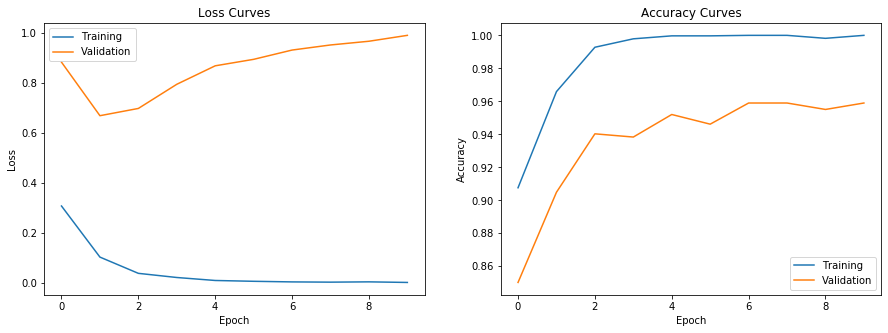

In [12]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=3, bias=True)

loss_func = nn.CrossEntropyLoss(weight=torch.tensor([98/2551, 98/608, 98/98]).to(device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)
train_losses, train_accs, val_losses, val_accs, best = train(model, optimizer, loss_func, epochs=10)

#Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_losses, label='Training')
axs[0].plot(val_losses, label='Validation')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Loss Curves')
axs[0].legend()

axs[1].plot(train_accs, label='Training')
axs[1].plot(val_accs, label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Accuracy Curves')
axs[1].legend()

plt.show()

In [13]:
test(best['model'], loss_func)

Mask Accuracy: 330/353 -> 0.93484
No Mask Accuracy: 36/42 -> 0.85714
Incorrect Mask Accuracy: 7/13 -> 0.53846


(0.5470557436347008,
 0.9147135416666666,
 0.9348441926345609,
 0.8571428571428571,
 0.5384615384615384)

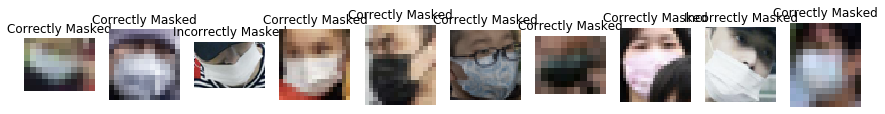

In [14]:
test_predict(best['model'])

In [15]:
torch.save(model.state_dict(), 'best_model.pt')

In [16]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    return model

rcnn_model = get_model_instance_segmentation(3) 
rcnn_model.load_state_dict(torch.load('rcnn_model.pt'))
rcnn_model.eval()
rcnn_model = rcnn_model.to(device=device)

In [17]:
def pip_face_recognition(img_path):
    fr_image = face_recognition.load_image_file(img_path)
    face_locations = face_recognition.face_locations(fr_image)
    return face_locations

def faster_rcnn(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = T.functional.to_tensor(img)
    img_tensor = img_tensor.to(device=device)
    pred = rcnn_model(torch.unsqueeze(img_tensor, 0))
    
    rearranged = []
    for l in pred[0]['boxes'].cpu().detach().numpy():
        rearranged.append([l[1], l[2], l[3], l[0]])
    return rearranged
    
def face_detection_and_prediction(model, face_detector, num_images=30):
    fig, axs = plt.subplots(num_images, 1, figsize=(10, num_images*5))
    
    predict_dict = {0: 'tab:green', 1: 'tab:red', 2: 'tab:orange'}
    
    model = model.to(device='cpu') 
    model.eval() 
    with torch.no_grad():
        for count, img_name in tqdm(enumerate(sorted(os.listdir('./images'), reverse=True))):
            if count == num_images:
                break
            img_path = os.path.join('./images', img_name)
            face_locations = face_detector(img_path)
            
            pil_img = Image.open(img_path).convert('RGB')
            axs[count].imshow(pil_img)
            axs[count].axis('off')
            
            for top, right, bottom, left in face_locations:
                cropped_img = pil_img.crop((left, top, right, bottom))
                # Normalize stats from ImageNet
                compose = T.Compose([
                    T.Resize((35, 35)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
                ])
                
                scores = model(torch.unsqueeze(compose(cropped_img), 0))
                preds = torch.argmax(scores, axis=1)
                
                rect = patches.Rectangle((left, top), right-left, bottom-top, linewidth=3, 
                                         edgecolor= predict_dict[preds[0].item()], facecolor='none')
                axs[count].add_patch(rect)
            
    plt.show()

30it [00:26,  2.02it/s]

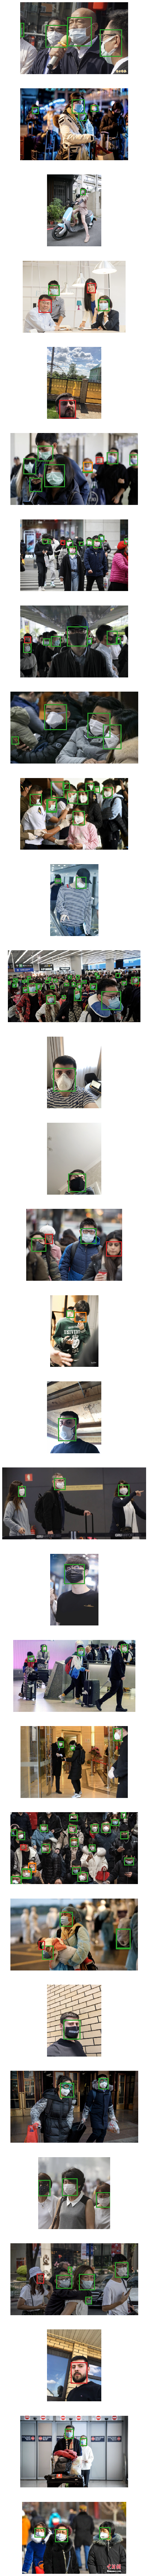

In [18]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=3, bias=True)
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

face_detection_and_prediction(model, face_detector=faster_rcnn)